## Configuration

### Imports

In [1]:
# Utilities
from IPython.display import display
import os
import numpy as np
import time
import pandas as pd
from fastprogress import master_bar, progress_bar

# MongoDB functionality
from pymongo import MongoClient, InsertOne, UpdateOne
from bson import ObjectId
from collections.abc import MutableMapping

# Graphics
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set(font_scale=0.9)
sns.set_style("whitegrid")
sns.set_style({'font.family':'monospace'})


# Network analysis
import networkx as nx

ROOT_DIR = "/home/mattia/javier/botbusters-spanish-general-elections-network-analysis/"

# Change path to root
os.chdir(ROOT_DIR)

# MongoDB parameters
mongoclient = MongoClient('localhost', 27017)
db = mongoclient.influence

In [2]:
sns.__version__

'0.11.0'

### Support Functions

In [3]:
def flatten(d, parent_key='', sep='_'):
    """Formats MongoDB results
    
    Keyword arguments:
    d -- dictionary with key and uncleaned values
    parent_key --
    sep --
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def make_objid(text):
    """Makes an ObjectId of 4 bytes
    
    Keyword arguments:
    text -- string to be converted into Object ID
    """
    text = str(text)
    if not text.strip():
        return None
    try:
        return ObjectId(text.rjust(24,"0"))
    except Exception as ex:
        print(text, ex)
        return None

LIMIT=6*500000
    
def get_tweets(collection):
    """
    Gets tweets
    
    collection - Tweets MongoDB collection
    """
    tweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                   )
    
    print("Number of tweets:", len(tweets))
    tweets = [flatten(t) for t in tweets]
    df_tweets = pd.DataFrame(tweets)
    df_tweets.user_id = df_tweets.user_id.apply(lambda t : str(t))
    df_tweets.user_id = df_tweets.user_id.astype(str)
    df_tweets.rename(columns={'user_id':'tweet_author'},inplace=True)
    return df_tweets
    
    
def get_retweets(collection):
    """
    Gets retweets
    
    collection - Retweets MongoDB collection
    """
    retweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                    .limit(LIMIT)
                   )
    
    print("Number of retweets:", len(retweets))
    retweets = [flatten(r) for r in retweets]
    df_retweets = pd.DataFrame(retweets)
    df_retweets.user_id = df_retweets.user_id.apply(lambda t : str(t))
    df_retweets.user_id = df_retweets.user_id.astype(str)
    df_retweets.rename(columns={'user_id':'retweet_author'},inplace=True)
    return df_retweets

def get_users(collection):
    """
    Gets users
    
    collection - Users MongoDB collection
    """
    users = list(collection.find({ '$and' : [ { 'sampled': True } , { 'botscore' : { '$gte' : 0 } }]},
                                 {'_id' : True, 'botscore' : True})
                 #.limit(LIMIT)
                )
    print("Number of sampled users with botscore in DB:", len(users))
    users = [flatten(u) for u in users]
    df_users = pd.DataFrame(users)
    df_users._id = df_users._id.apply(lambda t : str(t))
    df_users._id = df_users._id.astype(str)
    return df_users

## Data preparation

#### Getting tweets from DB...

In [4]:
df_tweets = get_tweets(db.tweets)
df_tweets.head(3)

Number of tweets: 358190


,tweet_author,tweet_id
0,000000000000000279465279,000001191464087064109058
1,000000000000001266667238,000001192787272975945729
2,000000000000000331220696,000001191467194519080960


In [5]:
df_tweets[df_tweets.duplicated()].count()
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358190 entries, 0 to 358189
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tweet_author  358190 non-null  object
 1   tweet_id      358190 non-null  object
dtypes: object(2)
memory usage: 5.5+ MB


In [6]:
df_tweets.drop_duplicates(keep='first', inplace=True)

#### Getting retweets from DB...

In [7]:
df_retweets = get_retweets(db.retweets)
df_retweets.head(3)

Number of retweets: 3000000


,tweet_id,retweet_author
0,000001193667913368121351,000000000000004460826197
1,000001192581634291355649,000001075150211725619200
2,000001190659978471911424,000000000000000071190801


In [8]:
df_retweets[df_retweets.duplicated()].count()

tweet_id          1131
retweet_author    1131
dtype: int64

In [9]:
df_retweets.drop_duplicates(keep='first', inplace=True)
df_retweets.count()

tweet_id          2998869
retweet_author    2998869
dtype: int64

#### Getting users form DB

In [10]:
users = get_users(db.users)
display(users.head(5))

Number of sampled users with botscore in DB: 458072


,_id,botscore
0,000000000000002266588688,0.16
1,000000000000000471028961,0.03
2,000000000000002792368467,0.11
3,000000000000004068857357,0.01
4,000000000000000006953012,0.03


#### Build directed-weighted retweet graph

In [11]:
df_edges = df_retweets.set_index('tweet_id').join(df_tweets.set_index('tweet_id')).reset_index(drop=True)
df_edges.head(5)

,retweet_author,tweet_author
0,000000000000001125213258,000000000000000022488241
1,000000000000000250738602,000000000000000022488241
2,000000000000000194176051,000000000000000022488241
3,000000000000000376943216,000000000000000022488241
4,000001121249610612260865,000000000000000022488241


In [12]:
df_edges = df_edges.groupby(['retweet_author','tweet_author']).size().reset_index().rename(columns={0:'weight'})
df_edges.head(5)

,retweet_author,tweet_author,weight
0,000000000000000000003065,000000000000000016409683,1
1,000000000000000000003065,000000000000000121385551,1
2,000000000000000000003065,000000000000000207741909,1
3,000000000000000000003971,000000000000000006293922,1
4,000000000000000000003971,000000000000000142395787,1


In [13]:
implicated_users = []
implicated_users = list(set(list(df_edges.retweet_author.unique()) + list(df_edges.tweet_author.unique())))
#print("Implicated users:", len(implicated_users))

df_users = users[users._id.isin(implicated_users)]
print("Users with botscore:", len(df_users))

print("Retweets without botscore:", len(df_edges))
df_edges = df_edges[(df_edges.retweet_author.isin(df_users._id)) & (df_edges.tweet_author.isin(df_users._id))]
print("Retweets with botscore:", len(df_edges))

Users with botscore: 363073
Retweets without botscore: 2561391
Retweets with botscore: 1483832


In [14]:
G = nx.from_pandas_edgelist(df=df_edges, source='tweet_author', target='retweet_author', edge_attr='weight', create_using=nx.DiGraph)
node_attr = df_users.set_index('_id').to_dict('index')
nx.set_node_attributes(G, node_attr)

## 1. Network robutness

#### Relationship botscore/random vs % of METRICS

In [15]:
%%time

data = {'weights': [0,0],
    'giant nodes': [0,0],
    #'edges':[0,0],
    'nodes' : [0,0],
    'percentile':[0,0],
    'mode':['descending botscore', 'random']
}

prs = list(range(10,110,10))
ps = np.percentile(a=users.index, q=prs)
percentile = dict(zip(prs,ps))
print(percentile)

H = G.subgraph(list(users['_id']))
INITIAL_WEIGHTS = H.size(weight='weight')
INITIAL_NODES = H.number_of_nodes()
#INITIAL_EDGES = H.number_of_edges()   
components= sorted(nx.connected_components(H.to_undirected()), key=len, reverse=True)
INITIAL_GIANT_NODES = len(components[0])


for mode in ['descending botscore', 'random']:

    if mode == 'descending botscore':
        subset_users = users.sort_values(by='botscore',axis='index',ascending=False)
    else:
        subset_users = users.sample(frac=1).reset_index(drop=True)

    display(subset_users.info())
    
    for percentage in progress_bar(prs):

        perc = int(percentile[percentage])-1
        nodes = list(subset_users.head(perc)['_id'])

        H = G.subgraph(nodes)

        total_weights = H.size(weight='weight')/INITIAL_WEIGHTS
        total_nodes = H.number_of_nodes()/INITIAL_NODES
        #total_edges = H.number_of_edges()/INITIAL_EDGES
        components = sorted(nx.connected_components(H.to_undirected()), key=len, reverse=True)
        total_giant = len(components[0]) / INITIAL_GIANT_NODES

        data['weights'].append(total_weights)
        data['nodes'].append(total_nodes)
        #data['edges'].append(total_edges)
        data['percentile'].append(percentage)
        data['giant nodes'].append(total_giant)
        data['mode'].append(mode)

{10: 45807.100000000006, 20: 91614.20000000001, 30: 137421.3, 40: 183228.40000000002, 50: 229035.5, 60: 274842.6, 70: 320649.69999999995, 80: 366456.80000000005, 90: 412263.9, 100: 458071.0}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 458072 entries, 31292 to 77160
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _id       458072 non-null  object 
 1   botscore  458072 non-null  float64
dtypes: float64(1), object(1)
memory usage: 10.5+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458072 entries, 0 to 458071
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _id       458072 non-null  object 
 1   botscore  458072 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.0+ MB


None

CPU times: user 8min 16s, sys: 11 s, total: 8min 27s
Wall time: 8min 30s


In [16]:
df= pd.DataFrame.from_dict(data,orient='columns')
df.head()

,weights,giant nodes,nodes,percentile,mode
0,0.000000,0.000000,0.000000,0,ascending botscore
1,0.000000,0.000000,0.000000,0,random
2,0.007165,0.013503,0.099480,10,ascending botscore
3,0.032086,0.053180,0.201263,20,ascending botscore
4,0.077312,0.112508,0.303683,30,ascending botscore


In [17]:
pd.melt(df,['percentile','mode']).sort_values(by='percentile', ascending=False, ignore_index=True).head()

,percentile,mode,variable,value
0,100,ascending botscore,giant nodes,0.999997
1,100,ascending botscore,weights,0.999992
2,100,ascending botscore,nodes,0.999997
3,100,random,giant nodes,0.999997
4,100,random,weights,0.999997


(100.0, 0.0)

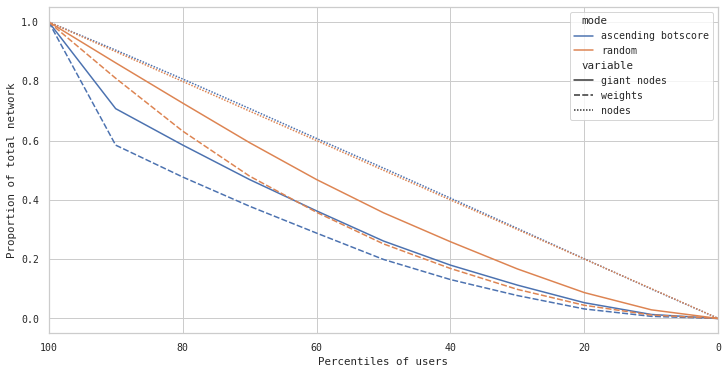

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(12,6))

ax = sns.lineplot(x='percentile',
                  y='value',
                  style='variable',
                  hue='mode',
                  data=pd.melt(df,['percentile','mode']).sort_values(by='percentile', ascending=False, ignore_index=True),
                  sort=False)

# Put the legend out of the figure
ax.set_ylabel(ylabel='Proportion of total network')
ax.set_xlabel(xlabel='Percentiles of users')
ax.set_xlim(100,0)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)